# Segmentation Of Tumors From Medical Resonance Imaging Scans Utilizing gradCAM Algorithm

The purpose of this project is to compare different pretrained deep learning models and custom models in segmentation and classification tasks on Medical Resonance Imaging(MRI) scans and identify the model and parameters with highest accuracy, to assist radiologists in analysing MRI modalities by providing confirmation about the diagnosis as well as localising the tumor(s).

In [1]:
#Adding sibling directory to path of current directory
import sys
import os
# Adding Dataset to import path
sibling_dir = "/home/wizard/codestuff/brain-tumor-classification/dataset"
sys.path.insert(1, sibling_dir)

## a) Project Imports
- Dataset
- Plotting Libraries


In [2]:
from EDAtorchData import torchData

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "png"

## b) Initialisation
We intialize the Training and the Testing dataset as it has been split already.

In [3]:
testData = torchData(sibling_dir+"/Testing")
trainData = torchData(sibling_dir+"/Training")
validationData = torchData(sibling_dir+"/Validation")
totalImages = sum(len(i) for i in [testData, trainData, validationData])
dist = [len(i)*100/totalImages for i in [testData, trainData, validationData]]

hi
/home/wizard/codestuff/brain-tumor-classification/dataset/Testing
hi
/home/wizard/codestuff/brain-tumor-classification/dataset/Training
hi
/home/wizard/codestuff/brain-tumor-classification/dataset/Validation


## Data Visualisation And Exploration

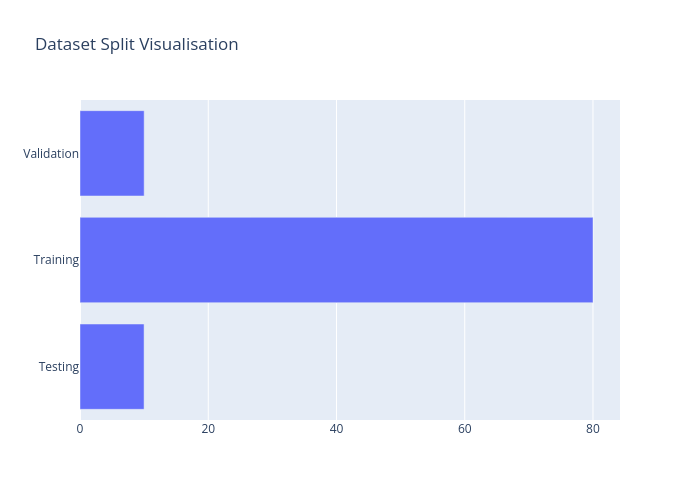

In [4]:
splitBar = go.Figure(go.Bar(y=["Testing", "Training", "Validation"],
      x=dist, orientation="h", hovertemplate='<i>Percentage:</i> %{x:.2f} %'))
splitBar.update_layout(title="Dataset Split Visualisation")
splitBar.show()

### i) Train Test Val Split

## ii)Class Distribution
For finding the class distribution we will use a simple counting loop for all the datasets and count the number of occurences of each encoded label.

In [5]:
def classCounts(labels: list[str])-> dict[int, int]:
    result = {i: 0 for i in labels}
    for i in labels:
        result[i]+=1
    return result
trainClasses = classCounts(trainData.imageLabels)
testClasses = classCounts(testData.imageLabels)
valClasses = classCounts(validationData.imageLabels)

### 1) For the Testing set

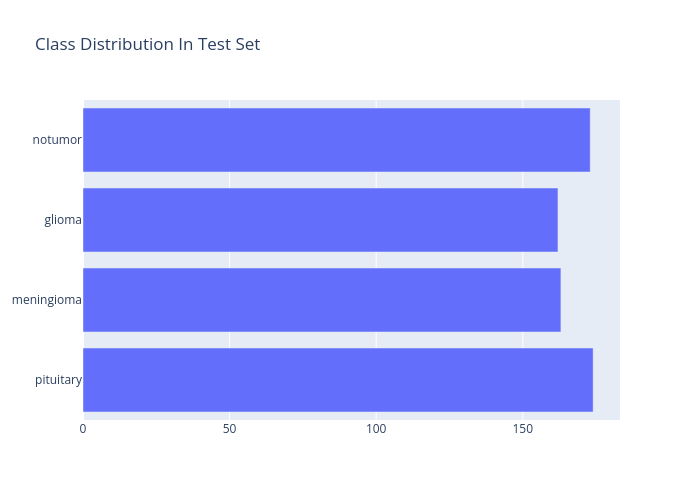

In [6]:
testDist = go.Figure(go.Bar(x=list(testClasses.values()), y=list(testData.classLabels.values()),orientation="h"))
testDist.update_layout(title="Class Distribution In Test Set")
testDist.show()

### 2)For The Training set

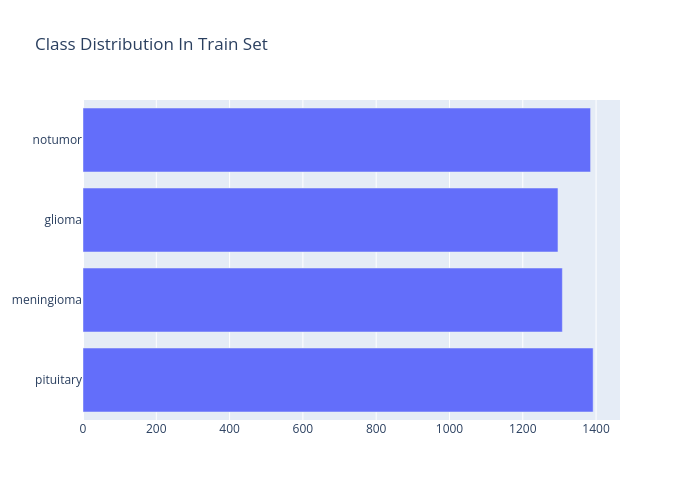

In [15]:
trainDist = go.Figure(go.Bar(x=list(trainClasses.values()), y=list(trainData.classLabels.values()),orientation="h"))
trainDist.update_layout(title="Class Distribution In Train Set")

### 3) Validation Set

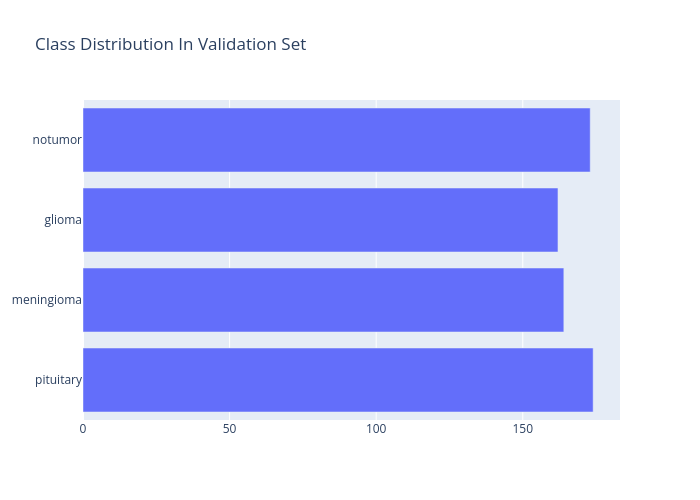

In [8]:
trainDist = go.Figure(go.Bar(x=list(valClasses.values()), y=list(trainData.classLabels.values()),orientation="h"))
trainDist.update_layout(title="Class Distribution In Validation Set")

### iii) Image Visualization

### 1)Testing Set

In [9]:
testImages = [testData[(-1,i)] for i in testData.classLabels.keys()]
testImages

[(<PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>, 1),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>, 2),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225>, 3)]

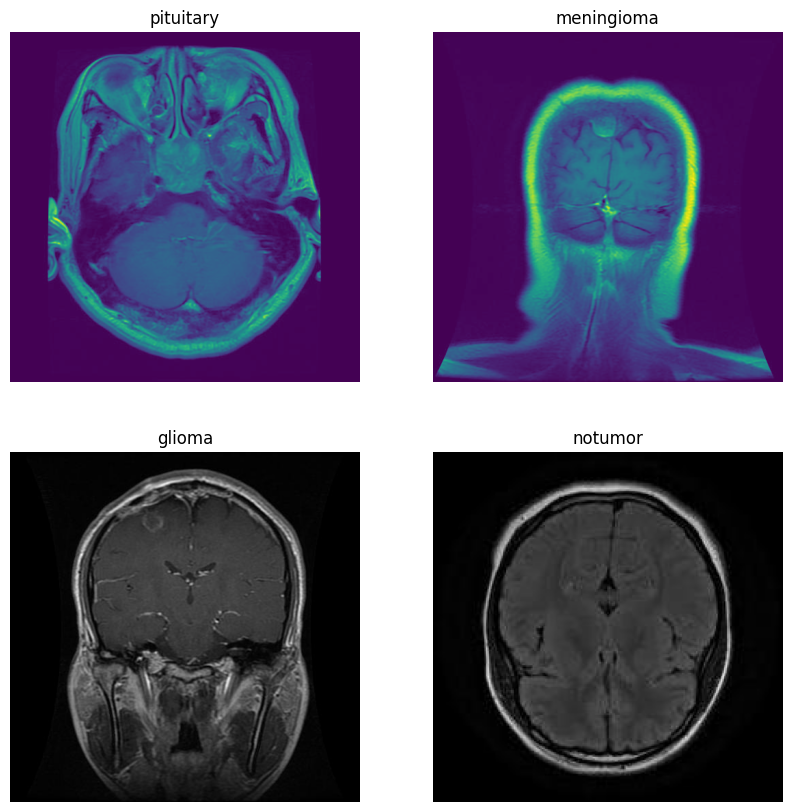

In [10]:
plt.figure(figsize=(10,10))
for i in testImages:
    plt.subplot(2,2, i[1]+1)
    plt.imshow(i[0])
    plt.title(testData.classLabels[i[1]])
    plt.axis('off')

### 2)Training Set

In [11]:
trainImages = [trainData[(-1, i)] for i in trainData.classLabels.keys()]
trainImages

[(<PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>, 1),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>, 2),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=236x236>, 3)]

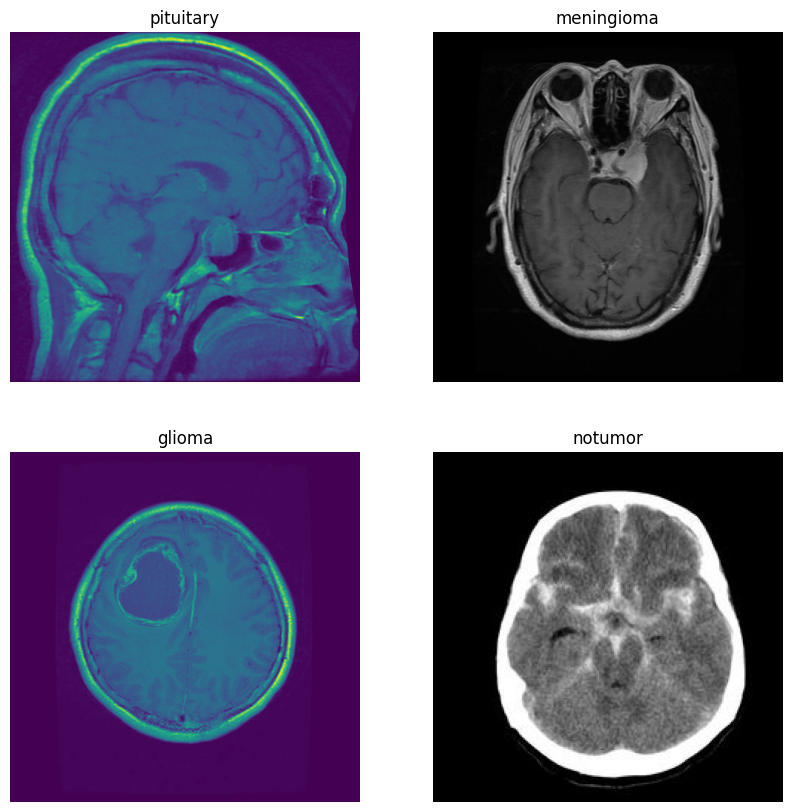

In [12]:
plt.figure(figsize=(10,10))
for i in trainImages:
    plt.subplot(2,2, i[1]+1)
    plt.imshow(i[0])
    plt.title(testData.classLabels[i[1]])
    plt.axis('off')

### 3) Validation Set

In [13]:
valImages = [validationData[(-1, i)] for i in validationData.classLabels.keys()]
valImages

[(<PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>, 1),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>, 2),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=218x231>, 3)]

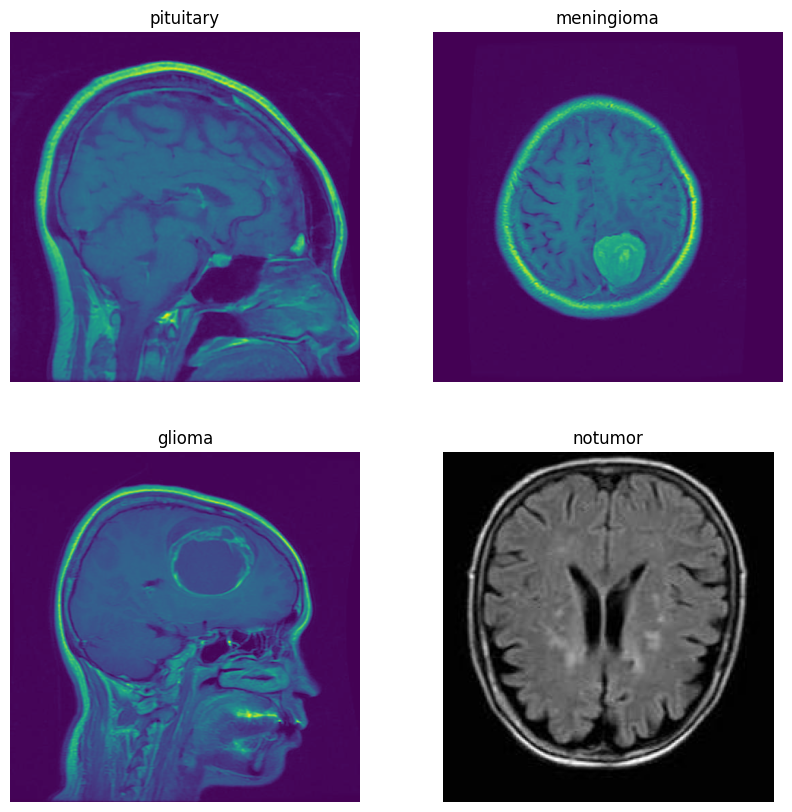

In [14]:
plt.figure(figsize=(10,10))
for i in valImages:
    plt.subplot(2,2, i[1]+1)
    plt.imshow(i[0])
    plt.title(validationData.classLabels[i[1]])
    plt.axis('off')

## Resolution Counts For Images

In [11]:
def getResCount(paths: list[str])-> dict[tuple[int,int], int]:
    resCount = {}
    for j in paths:
        image = Image.open(j)
        if image.size not in resCount:
            resCount[image.size] = 1
        else:
            resCount[image.size] += 1
    return resCount
trainResCounts = getResCount(trainData.imagePaths)
testResCounts = getResCount(testData.imagePaths)
valResCounts = getResCount(validationData.imagePaths)

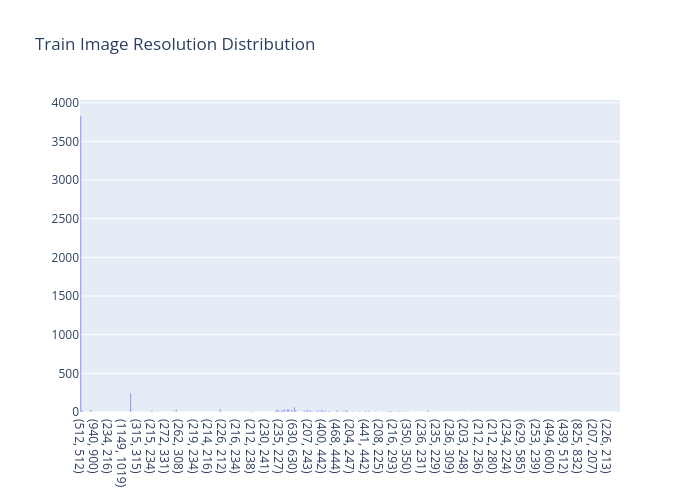

In [12]:
trainResPlot = go.Figure(go.Bar(x=[str(i) for i in trainResCounts.keys()], y =list(trainResCounts.values())))
trainResPlot.update_layout(title="Train Image Resolution Distribution")
trainResPlot.show()

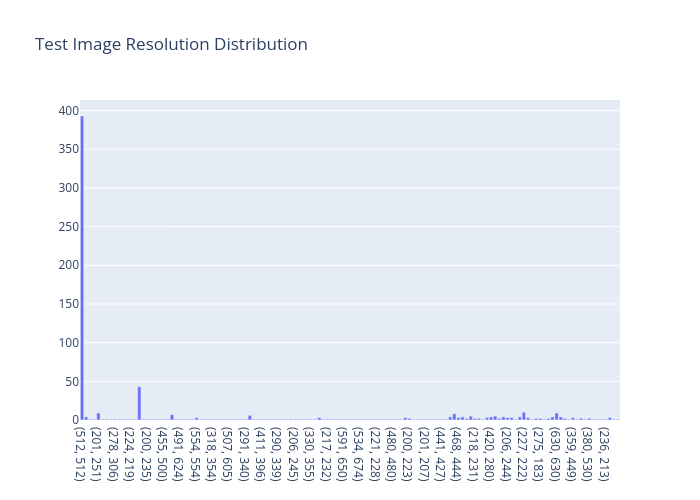

In [13]:
testResPlot = go.Figure(go.Bar(x=[str(i) for i in testResCounts.keys()], y =list(testResCounts.values())))
testResPlot.update_layout(title="Test Image Resolution Distribution")
testResPlot.show()

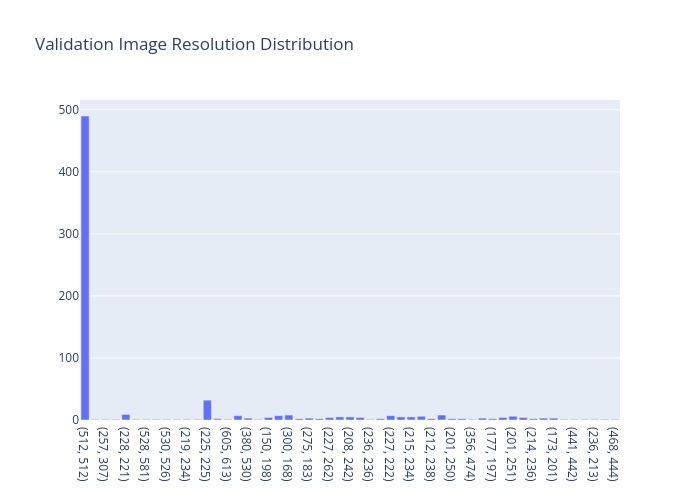

In [14]:
valResPlot = go.Figure(go.Bar(x=[str(i) for i in valResCounts.keys()], y =list(valResCounts.values())))
valResPlot.update_layout(title="Validation Image Resolution Distribution")
valResPlot.show()

<b>From the above plots, we can see that majority of the images have a resolution corresponding to 512px512p, however this would require an input layer with 262,144 features and an output layer consisting of 4 neurons, one for each image class. To optimize training times and reduce the risk of model overfitting, we will normalize the image resolution across all images to 256 x 256, which reduces the input layer to 65,536 features, which is easier to handle. This transformation will be handled by torch.transforms</b>

# Conclusion:

After the exploratory data analysis, we have identified the characteristics of the dataset and confirmed
that noise is minimal in the dataset and the categorical distribution is balanced enough to be utilized
for any further development.
Further preprocessing steps include:
- Standardize image resolutions in the dataset to ensure generalization of the model.
- Convert to grayscale or modify opacity of images to differentiate between brain matter and the tumor.